In [1]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt

import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.models as models
import mlgrad.loss as loss
import mlgrad.boost.anyboost as anyboost

In [2]:
X, Y = datasets.make_moons(200, noise=0.25)
Y = 2*Y-1
Y = Y.astype("d")

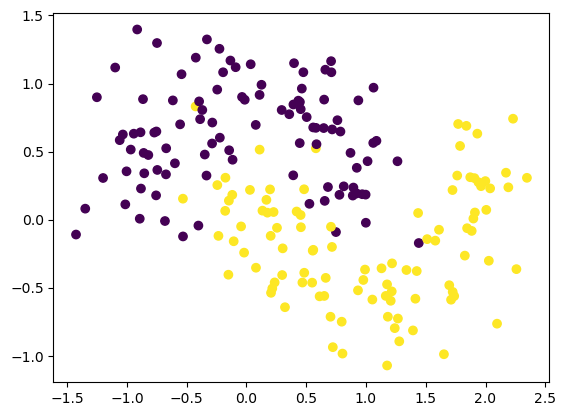

In [3]:
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [4]:
cls = anyboost.AnyBoostClassification(func=funcs.SoftHinge_Exp(1.0), n_iter=100)
cls.fit(X, Y, regnorm=funcs2.SquareNorm(), tau=0.5)

In [5]:
print(np.asarray(cls.H.weights))

[1.644e-01 8.735e-06 6.114e-02 1.270e-06 4.919e-02 1.862e-06 4.238e-02
 1.905e-02 1.030e-02 3.647e-03 5.672e-02 2.431e-03 2.645e-02 1.531e-04
 3.465e-02 2.588e-02 7.322e-03 3.379e-02 1.682e-04 4.452e-04 2.680e-02
 1.904e-02 5.191e-03 1.244e-02 1.610e-02 1.867e-03 2.125e-02 3.395e-03
 1.421e-02 1.411e-02 2.611e-02 5.190e-03 1.666e-02 7.010e-03 1.802e-02
 1.486e-02 1.231e-03 2.187e-02 1.117e-02 2.078e-02 3.731e-04 1.558e-02
 1.415e-02 2.199e-03 1.881e-02 1.816e-03 1.092e-02 6.720e-03 5.215e-10
 5.360e-03 1.283e-02 1.440e-03 7.333e-10 1.479e-09 1.965e-02 4.784e-03
 9.214e-03 1.437e-02 3.036e-03 1.944e-02 1.003e-02 7.670e-04 1.310e-02]


In [6]:
metrics.accuracy_score(np.sign(cls.H.evaluate(X)), Y)

0.955

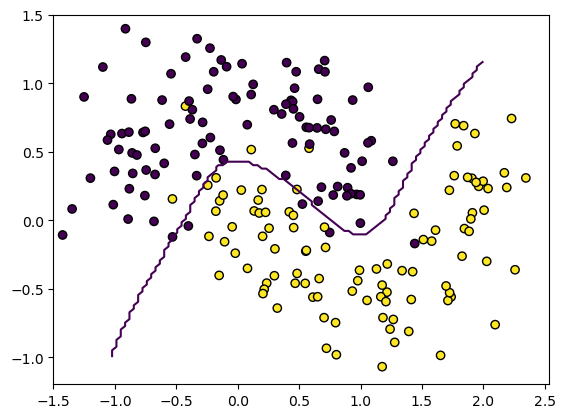

In [7]:
XX, YY = np.meshgrid(np.linspace(-1.5, 2.0, 100), np.linspace(-1.0, 1.5, 100))
XY = np.c_[XX.ravel(), YY.ravel()]
ZZ = np.sign(cls.H.evaluate(XY))
ZZ = ZZ.reshape(XX.shape)
plt.scatter(X[:,0], X[:,1], c=Y, edgecolors='k')
plt.contour(ZZ, extent=(-1.5, 2.0, -1.0,1.5), levels=[0])
plt.show()